# ROOT CINT/CLING basics (C++)

## Objectives:
* How to open a TFile?
* How to inspect it?
* How to create/draw  histogram (1D/2D)?
* Loop on TTree entries
* Fit function

---

In this notebook ";" are compulsory at the end of line (in case of multiple lines).

## Open a TFile

In [ ]:
TFile *f1 = new TFile("data/mc_147771.Zmumu.root")

In [ ]:
%jsroot on

In [ ]:
f1->ls()

descend in the TTree.
mini is already a pointer to a TTree you don't need to execute the next cell

In [ ]:
TTree *t1 = (TTree*)f1->Get("mini");

## Inspect the "mini" TTree

In [ ]:
t1->ls();
t1->Print()

How many events are stored in the ntuple?
We have in the ntuple primitive types like   **eventNumber/I** 
    Which type is it?
vectors primitive types like **lep_pt[lep_n]/F** 
    Which is the size of the vector?
    Which types are the elements of that vector?

Scan numerically some elements of the TTree. Don't remove the "10" in command line, it will crash the kernel of this notebook
Usefull command if you want to have a first look at the variables.
Scan("variable1:variable2:",condition, format, number of rows to be printed)

In [ ]:
t1->Scan("eventNumber:vxp_z:lep_n:lep_pt","","colsize=5 precision=3 col=::20.10:6",10)

Implementing cuts

In [ ]:
t1->Scan("eventNumber:vxp_z:lep_n:lep_pt","lep_pt>40000","",10)

In [ ]:
t1->Scan("eventNumber:vxp_z:lep_n:lep_pt","","colsize=5 precision=3",10)

In [ ]:
t1->Scan("eventNumber:vxp_z:lep_n:lep_pt","","colsize=5 precision=3 col=::20.10:6",10)

Now draw the variables
Digression: Almost all objects you will create are inheriting from TNamed object. Obscure way to say that when instantiating objects you have:
* The variable name (varname) you access your object in C++ (e.g. TCanvas \*c1)
* The name (hname) with which ROOT access the object in its memory (first argument of constructor). You have to use this to retrieve the object from ROOT memory e.g. gDirectory->GetObject("c1"). varname and hname can be the same (like in all the examples I'm using today, confusing, I know) but they indicate different things!
* The title of the object (tname: you see it on the TBrowser)

In [ ]:
TCanvas *c1 = new TCanvas("c1","My New Canvas",600,600);
t1->Draw("lep_pt");
c1->Draw()

Do you like this plot?

In [ ]:
t1->Draw("lep_pt","lep_pt<100000");
c1->Draw()

In [ ]:
t1->Draw("lep_pt[0]","lep_pt[0]<100000");
c1->Draw()

In [ ]:
htemp->Draw();
c1->Draw()

The TTree::Draw result is stored on htemp histogram but you have no control on it (bin size, intervals, etc). You need to create your own histogram.

In [ ]:
TH1F *h1 = new TH1F("h1","Leading Lepton Pt",100,0,100000);
t1->Draw("lep_pt[0]>>h1");
h1->Draw();
c1->Draw();

In [ ]:
h1->SetLineColor(kRed);
h1->SetLineWidth(3);
h1->SetLineStyle(2);
h1->SetFillStyle(3024);
h1->SetFillColor(kPink+10);
h1->Draw();
c1->Draw();

In [ ]:
TH1F *h2 = new TH1F("h2","SubLeading Lepton Pt",100,0,100000);
t1->Draw("lep_pt[1]>>h2");
h2->Draw();

In [ ]:
c1->Draw()

In [ ]:
h1->Draw();
h2->Draw("same");
c1->Draw()

Note: If you are using ROOT on terminal you can interact with the plots using the GUI. You can zoom/unzoom axis, logscale, change graphical attributes, fit (cf later) etc...

## How to create 2D Histograms

In [ ]:
t1->Draw("lep_pt[0]:lep_pt[1]","lep_pt[0]<100000 && eventNumber<50000");
c1->Draw()

Note: This is called "scatter plot". And it plots var1 (y-axis) vs var2 (x-axis). 
What do you learn from this plot?
Let's fill a proper TH2F (2-Dimension hisogram)

In [ ]:
TH2F *hpt1vspt2 = new TH2F("hpt1vspt2","Leading vs Subleading Lepton Pt",50,0,100000,50,0,100000);
t1->Draw("lep_pt[0]:lep_pt[1]>>hpt1vspt2");
hpt1vspt2->Draw();
c1->Draw();

In [ ]:
hpt1vspt2->Draw("lego");
c1->Draw()

In [ ]:
hpt1vspt2->Draw("colz");
c1->Draw()

Try other graphical options for TH1::Draw("options"). e,g. CONT, SURF1, BOX etc...

In 2D plot usually we want to udnerstand if one variable is a function of the other.

In [ ]:
TProfile *hprof = new TProfile("hprof","Profile along px",50,0,100000);
hprof = hpt1vspt2->ProfileX();

In [ ]:
hprof->Draw();
c1->Draw();

Try to change option in TProfile constructor (last argument):
 * ' ' (Default) the bin errors are the standard error on the mean of Y = S(Y)/SQRT(N) where S(Y) is the standard deviation (RMS) of the Y data in the bin and N is the number of bin entries (from TProfile::GetBinEntries(ibin) ) (i.e the errors are the standard error on the bin content of the profile)
 * 's' Errors are the standard deviation of Y, S(Y)
 * 'i' Errors are S(Y)/SQRT(N) (standard error on the mean as in the default) The only difference is only when the standard deviation in Y is zero. In this case the error a standard deviation = 1/SQRT(12) is assumed and the error is 1./SQRT(12*N). This approximation assumes that the Y values are integer (e.g. ADC counts) and have an implicit uncertainty of y +/- 0.5. With the assumption that the probability that y takes any value between y-0.5 and y+0.5 is uniform, its standard error is 1/SQRT(12)
 * 'g' Errors are 1./SQRT(W) where W is the sum of the weights for the bin J W is obtained as from TProfile::GetBinEntries(ibin) This errors corresponds to the standard deviation of weighted mean where each measurement Y is uncorrelated and has an error sigma, which is expressed in the weight used to fill the Profile: w = 1/sigma^2 The resulting error in TProfile is then 1./SQRT( Sum(1./sigma^2) )

## Plot non standard variable

You need to access the TTree variables and perform some computation

In [ ]:
double mass_mumu;
UInt_t          lep_n;
Float_t         lep_pt[6];
Float_t         lep_eta[6];
Float_t         lep_phi[6];
Float_t         lep_charge[6];
UInt_t          lep_type[6];
Float_t         lep_E[6]; 


 t1->SetBranchAddress("lep_n", &lep_n);
 t1->SetBranchAddress("lep_pt", lep_pt);
 t1->SetBranchAddress("lep_eta", lep_eta);
 t1->SetBranchAddress("lep_phi", lep_phi);
 t1->SetBranchAddress("lep_charge", lep_charge);
 t1->SetBranchAddress("lep_type", lep_type);
 t1->SetBranchAddress("lep_E", lep_E);


TH1F *h_mumu=new TH1F("h_mumu","Invariant mass",50,50,150);

int nEntries = t1 -> GetEntries();
if (nEntries>10000) nEntries=10000; //(uncomment if you want to give a quick try)
for(int i = 0; i < nEntries; ++i){
    t1->GetEntry(i);
    if(lep_n>=2){
      double px = lep_pt[0]*cos(lep_phi[0])+lep_pt[1]*cos(lep_phi[1]);
      double py = lep_pt[0]*sin(lep_phi[0])+lep_pt[1]*sin(lep_phi[1]);
      double theta1 = 2*atan(exp(-lep_eta[0]));
      double theta2 = 2*atan(exp(-lep_eta[1]));
      double pz = lep_pt[0]/tan(theta1)+lep_pt[1]/tan(theta2);
      double e = lep_E[0]+lep_E[1];
      mass_mumu = e*e-px*px-py*py-pz*pz;
      //std::cout << "mass:" << mass_mumu << std::endl;
      mass_mumu = sqrt(mass_mumu);
      h_mumu->Fill(mass_mumu/1000.);
    }
 }

c1->cd();
h_mumu->Draw();
c1->Draw();


A lot of tedious algebra. Can use TLorentzVector to to invariant mass

In [ ]:
TLorentzVector v1;
TLorentzVector v2;
TLorentzVector v3;


In [ ]:
TH1F *h_mumu_short=new TH1F("h_mumu_short","Invariant mass",50,50,150);
nEntries = t1 -> GetEntries();
if (nEntries>10000) nEntries=10000; // (uncomment if you want to give a quick try)
for(int i = 0; i < nEntries; ++i){
    t1->GetEntry(i);
    if(lep_n>=2){
        v1.SetPtEtaPhiE(lep_pt[0],lep_eta[0],lep_phi[0],lep_E[0]);
        v2.SetPtEtaPhiE(lep_pt[1],lep_eta[1],lep_phi[1],lep_E[1]);
        v3=v1+v2;
      mass_mumu = v3.Mag();
      //std::cout << "mass:" << mass_mumu << std::endl;
      h_mumu_short->Fill(mass_mumu/1000.);
    }
 }

c1->cd();
h_mumu->Draw();
c1->Draw();

## Fit histogram
 First attempt: use "gaus" predefined in ROOT
 Many other functions are predefined in root 
 ### predefined functions
* “gaus” Gaussian function with 3 parameters: f(x) = p0*exp(-0.5*((x-p1)/p2)^2)

* “expo” An Exponential with 2 parameters: f(x) = exp(p0+p1*x)

* “polN” A polynomial of degree N, where N is a number between 0 and 9: f(x) = p0 + p1*x + p2*x2 +...

* “chebyshevN” A Chebyshev polynomial of degree N, where N is a number between 0 and 9: f(x) = p0 + p1*x + p2*(2*x2-1) +...

* “landau” Landau function with mean and sigma. This function has been adapted from the CERNLIB routine G110 denlan (see TMath::Landau).

* "gausn" Normalized form of the gaussian function with 3 parameters f(x) = p0*exp(-0.5*((x-p1)/p2)^2)/(p2 *sqrt(2PI))

### fit options
* “W” Set all weights to 1 for non empty bins; ignore error bars
* “WW” Set all weights to 1 including empty bins; ignore error bars
* “I” Use integral of function in bin instead of value at bin center
* “L” Use log likelihood method (default is chi-square method). To be used when the histogram represents counts
* “WL” Weighted log likelihood method. To be used when the histogram has been filled with weights different than 1.
* “P” Use Pearson chi-square method, using expected errors instead of the observed one given by TH1::GetBinError (default case). The expected error is instead estimated from the the square-root of the bin function value.
* “Q” Quiet mode (minimum printing)
* “V” Verbose mode (default is between Q and V)
* “S” The result of the fit is returned in the TFitResultPtr.
* “E” Perform better errors estimation using the Minos technique
* “M” Improve fit results, by using the IMPROVE algorithm of TMinuit.
* “R” Use the range specified in the function range
* “N” Do not store the graphics function, do not draw
* “0” Do not plot the result of the fit. By default the fitted function is drawn unless the option “N” above is specified.
* “+” Add this new fitted function to the list of fitted functions (by default, the previous function is deleted and only the last one is kept)
* “B”Use this option when you want to fix one or more parameters and the fitting function is a predefined one, like polN, expo, landau, gaus. Note that in case of pre-defined functions some default initial values and limits are set.
* “C” In case of linear fitting, don’t calculate the chisquare (saves time).
* “F” If fitting a linear function (e.g. polN), switch to use the default minimizer (e.g. Minuit). By default, polN functions are fitted by the linear fitter.


In [ ]:
TH1F *h_mumu_fit1 = (TH1F*)h_mumu_short->Clone("h_mumu_fit1");
h_mumu_fit1->Fit("gaus");
h_mumu_fit1->Draw();
c1->Draw();
    

In [ ]:
TH1F *h_mumu_fit2 = (TH1F*)h_mumu_short->Clone("h_mumu_fit2");
h_mumu_fit2->Fit("gaus","","",86,96);
h_mumu_fit2->Draw();
c1->Draw();

User defined fit function. In such a way it is easier to get the parameters of the fit of the funtion. 

In [ ]:
Double_t mybw(Double_t* x, Double_t* par)
{
/*Definisco 2/pi */
  Double_t arg1 = 2/3.14;
/*Definisco i parametri Gamma[1] e Massa[2]*/
  Double_t arg2 = par[1]*par[1]*par[2]*par[2];
/*Definisco la funzione di Breit-Wigner*/
  Double_t arg3 = ((x[0]*x[0]) - (par[2]*par[2]))*((x[0]*x[0]) - (par[2]*par[2]));
  Double_t arg4 = x[0]*x[0]*x[0]*x[0]*((par[1]*par[1])/(par[2]*par[2]));
  return par[0]*arg1*arg2/(arg3 + arg4);
}
TF1 *BW = new TF1("mybw",mybw,0.485, 0.505,3);

In [ ]:

BW->SetParName(0,"const");  
BW->SetParameter(0,1.0);   
BW->SetParName(1,"Gamma");
BW->SetParameter(1,5); 
BW->SetParName(2,"Mass");
BW->SetParameter(2,91);     
TH1F *h_mumu_fit3 = (TH1F*)h_mumu_short->Clone("h_mumu_fit3");    
h_mumu_fit3->Fit("mybw");
h_mumu_fit3->Draw();
BW->Draw("same");
c1->Draw();

Now let's compare fit and function to fit in two different pads

In [ ]:
TH1F *hratio = (TH1F*)h_mumu_short->Clone("hratio");

In [ ]:
hratio->Divide(h_mumu_fit3->GetFunction("mybw"));

In [ ]:
TPad pad1("pad1","main",  0, 0.3, 1, 1.0);
TPad pad2("pad2","ratio", 0, 0.05, 1, 0.3);   

In [ ]:
TCanvas *c2 = new TCanvas("c2","My Second Canvas",600,400);

In [ ]:
c2->cd();
pad1.SetFillColor(0);
pad1.Draw();

                                             
pad2.SetFillColor(0);
pad2.Draw();

Go to the first pad and plot histogram and fit function

In [ ]:
pad1.cd();
h_mumu_short->Draw();
BW->Draw("same");

In [ ]:
c2->Draw()

Go to the second pad and plot ratio

In [ ]:
pad2.Clear();
pad2.cd();
hratio->Draw();

In [ ]:
c2->Draw()

## Graphs
Example on how to use graphs. For example do tag and probe and measure efficiency (TGraphAsymError)

In [ ]:
TCanvas *c3 = new TCanvas("c3","My Numerator denominator",600,400);


In [ ]:
//double mass_mumu;
//UInt_t          lep_n;
//Float_t         lep_pt[6];
//Float_t         lep_eta[6];
//Float_t         lep_phi[6];
//Float_t         lep_charge[6];
//UInt_t          lep_type[6];
//Float_t         lep_E[6]; 
Float_t         lep_etcone20[6];   //[lep_n]

In [ ]:
//TLorentzVector v1;
//TLorentzVector v2;
//TLorentzVector v3;


TH1F *h_pass_pt=new TH1F("h_pass_pt","Numerator Momentum",100,0,200);
TH1F *h_tot_pt=new TH1F("h_tot_pt","Denominator Momentum",100,0,200);

In [ ]:
 t1->SetBranchAddress("lep_n", &lep_n);
 t1->SetBranchAddress("lep_pt", lep_pt);
 t1->SetBranchAddress("lep_eta", lep_eta);
 t1->SetBranchAddress("lep_phi", lep_phi);
 t1->SetBranchAddress("lep_charge", lep_charge);
 t1->SetBranchAddress("lep_type", lep_type);
 t1->SetBranchAddress("lep_E", lep_E);
 t1->SetBranchAddress("lep_etcone20",lep_etcone20);

//int nEntries = t1 -> GetEntries();
if (nEntries>10000) nEntries=10000; //(uncomment if you want to give a quick try)

In [ ]:
for(int i = 0; i < nEntries; ++i){
    t1->GetEntry(i);
    if(lep_n<2) continue;
    for(int i1=0;i1<lep_n;++i1){
        if(lep_type[i1]!=13) continue;
        if(lep_etcone20[i1]>100) continue;
        v1.SetPtEtaPhiE(lep_pt[i1]/1000.,lep_eta[i1],lep_phi[i1],lep_E[i1]/1000.);
        for(int i2=0;i2<lep_n;++i2){
            if(i1==i2) continue;
            if(lep_type[i2]!=13) continue;
                mass_mumu=0;
             v2.SetPtEtaPhiE(lep_pt[i2]/1000.,lep_eta[i2],lep_phi[i2],lep_E[i2]/1000.);
    v3=v1+v2;
      mass_mumu = v3.Mag();
            if(fabs(mass_mumu-91)>5) continue;
            // this is the denominator
                h_tot_pt->Fill(lep_pt[i2]/1000);
            // this is the numerator
            if(lep_etcone20[i2]>100) continue;
            h_pass_pt->Fill(lep_pt[i2]/1000);
        }
    }
}
        
//TGraphAsymmErrors eff_pt;
cout << h_pass_pt->GetNbinsX() << endl;
 gr = new TGraphAsymmErrors(h_pass_pt);
gr->Divide(h_pass_pt,h_tot_pt);
gr->SetMarkerSize(21);
gr->SetMarkerColor(kRed);

c3->Clear();
c3->Divide(1,2);

c3->cd(1);
h_tot_pt->Draw();
h_pass_pt->Draw("same");
h_pass_pt->SetFillColor(kYellow);
auto legend = new TLegend(0.1,0.7,0.48,0.9);
   legend->SetHeader("Efficiency of EtCone20 selection","C"); // option "C" allows to center the header
   legend->AddEntry(h_tot_pt,"Denominator","f");
     legend->AddEntry(h_pass_pt,"Numerator","f");
   legend->AddEntry("gr","Efficiency","lep");
   legend->Draw();


c3->cd(2);
gr->Draw("AP");
c3->Draw();

*TODO:* TH1F variable bins size Example from last class: dynamically-sized histogram bins
TH1F* hist = new TH1F(name,title,Nbins,binEdgesArray)
TH1F* hist = new TH1F(name,title,bins.size()-1,&bins[0])
You can get C++ arrays in python through array or numpy
import array
binArray = array.array('f',binList)
hist = ROOT.TH1F(name,title,len(binList)-1,binArray)
The 'f' in the above is for 
oat, 'd' would be double, 'i' for int, etc
Numpy is instead (for a 32-bit 
oat = single-precision):
import numpy
binArray = numpy.array(binList,dtype=numpy.float32)

## Saving different histograms to file

In [1]:
 const int NUM_FILES = 2;
  TH1F *my_histo[NUM_FILES];
  for(int itree =0; itree<NUM_FILES;++itree){
    TFile *my_file;
    if(itree==0) {my_file= new TFile("data/mc_147771.Zmumu.root");}
    else  {my_file = new TFile("data/mc_117050.ttbar_lep.root");}
    char hname[20];
    sprintf(hname, "h_%d",itree);
    my_histo[itree] = new TH1F( hname , "" , 100 , 0. , 100.);
    TTree *my_t = (TTree*)my_file->Get("mini");
    char commandname[20];
    sprintf(commandname, "lep_pt[0]/1000.>>h_%d",itree);
    my_t->Draw(commandname);
  }
  TFile *newfile = new TFile("histo_file.root","RECREATE"); 
  for(int itree =0; itree<NUM_FILES;++itree){
    my_histo[itree]->Write();
  }
  newfile->Close();


Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


## Retrieve histograms from file

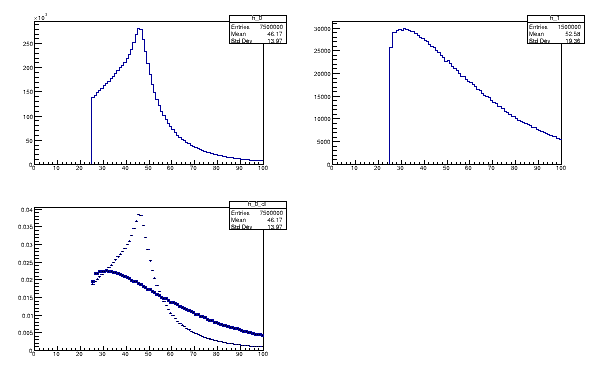

In [1]:
TFile *newfile = new TFile("histo_file.root","READ");
TCanvas *c4 = new TCanvas("c4","My 4th Canvas",600,400);
c4->Divide(2,2);

char name[20];
for(int j=0; j<2; ++j){
    sprintf(name, "h_%d",j);
    TH1F *h = (TH1F*)gDirectory->Get(name);
    c4->cd(j+1);
    h->Draw();
}
c4->cd(3);
TH1F *h_0 = (TH1F*)gDirectory->Get("h_0");
TH1F *h_0_cl = (TH1F*)h_0->Clone("h_0_cl");
TH1F *h_1 = (TH1F*)gDirectory->Get("h_1");
TH1F *h_1_cl = (TH1F*)h_1->Clone("h_1_cl");
h_0_cl->Sumw2();
h_1_cl->Sumw2();
h_0_cl->SetNormFactor(1);
h_1_cl->SetNormFactor(1);
h_0_cl->SetFillColor(5);
h_0_cl->Draw();
h_1_cl->SetLineWidth(3);  
h_1_cl->Draw("same");
  
c4->Draw();


## Use THStack to stack histograms

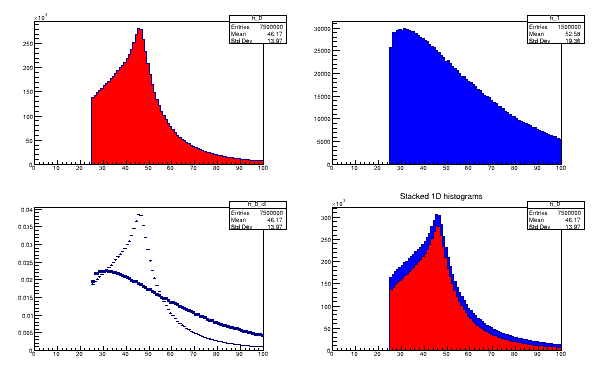

In [2]:
 c4->cd(4);
THStack *hs = new THStack("hs","Stacked 1D histograms");
h_0->SetFillColor(kRed);
   h_0->SetMarkerStyle(21);
   h_0->SetMarkerColor(kRed);
   hs->Add(h_0);
h_1->SetFillColor(kBlue);
   h_1->SetMarkerStyle(21);
   h_1->SetMarkerColor(kBlue);
   hs->Add(h_1);
hs->Draw();
c4->Draw();

## Create a subsample of event file 

Here we will read a file containing events, and will write to a new file only a subsample of it.

In [ ]:
TFile *f1 = new TFile("data/mc_147771.Zmumu.root");
TTree *t1 = (TTree*)f1->Get("mini");
gRandom = new TRandom3();
const auto nentries = t1->GetEntries();
t1->SetBranchStatus("*", 1);
TFile newfile("smaller.root", "recreate");
auto newtree = t1->CloneTree(0);
for (auto i : ROOT::TSeqI(nentries)) {
   t1->GetEntry(i);
    // simple minded
 //   if(i>10000) break;
// you can do something more clever using random 
     if(gRandom->Rndm()<(10000./nentries)){
    newtree->Fill();
     }
}

newtree->Print();
newfile.Write();
newfile.ls();    

In [ ]:
TTree *tsmall = (TTree*)newfile.Get("mini");
int nentries_small = tsmall->GetEntries();
cout << "nentries smaller file=" << nentries_small << endl;
cout << "nentries full file=" << nentries << endl;

# Root Macros
Now we will edit files

In [ ]:
%edit scripts/UnNamedMacro.cpp

In [ ]:
%%file scripts/UnNamedMacro.cpp
{
TCanvas *c1 = new TCanvas("c1","My Third Canvas",600,400);
TFile *f1 = new TFile("data/mc_147771.Zmumu.root");
f1->ls();
TH1F *h1 = new TH1F("h1","SubLeading Lepton Pt",100,0,100000);
# note the shortcut to use directly mini TTree
# this is NOT C++ !
mini->Draw("lep_pt[1]>>h1");

h1->Draw();
c1->Draw();
}


In [ ]:
.x scripts/UnNamedMacro.cpp

Now time to make our histogram prettier, paper journal quality style!

In [ ]:
%edit scripts/UnNamedMacro.cpp

In [ ]:
%%file scripts/UnNamedMacro.cpp
{
gStyle->SetOptTitle(0);
gStyle->SetOptStat(0);
gStyle->SetHistLineWidth(2.);
Int_t font=42; // Helvetica
Double_t tsize=0.05;
gStyle->SetTextFont(font);
gStyle->SetTextSize(tsize);


TCanvas *c1 = new TCanvas("c1","My Third Canvas",600,400);
TFile *f1 = new TFile("data/mc_147771.Zmumu.root");
f1->ls();
TH1F *h1 = new TH1F("h1","SubLeading Lepton Pt",100,0,100000);
mini->Draw("lep_pt[1]>>h1");
h1->Draw();

c1->Draw();
}

In [ ]:
%%file scripts/UnNamedMacro.cpp
{
gStyle->SetOptTitle(0);
gStyle->SetOptStat(0);
gStyle->SetHistLineWidth(2.);
Int_t font=42; // Helvetica
Double_t tsize=0.05;
gStyle->SetTextFont(font);
gStyle->SetTextSize(tsize);


TCanvas *c1 = new TCanvas("c1","My Third Canvas",600,400);
TFile *f1 = new TFile("data/mc_147771.Zmumu.root");
f1->ls();
TH1F *h1 = new TH1F("h1","SubLeading Lepton Pt",100,0,100000);
mini->Draw("lep_pt[1]>>h1");
h1->Draw();

c1->Draw();
}

In [ ]:
.x scripts/UnNamedMacro.cpp

writing a bunch of gStyle-> etc.... is tedious. Just define once for all in rootlogon.C (but doesn't seem to work on notebook). We will try that during tutorial

In [ ]:
%edit scripts/NamedMacro.cpp

In [ ]:
%%file scripts/NamedMacro.cpp
void NamedMacro(const char *my_draw){
  TCanvas *c1 = new TCanvas("c1","My Third Canvas",600,400);
  TFile *f1 = new TFile("data/mc_147771.Zmumu.root");
  f1->ls();
  TH1F *h1 = new TH1F("h1","SubLeading Lepton Pt",100,0,100000);
  TTree *t1 = (TTree*)f1->Get("mini");
  t1->Draw(my_draw);
  h1->Draw();
  c1->Draw();
}

In [ ]:
# this equivalent to .L scripts/NamedMacro.cpp
gROOT->ProcessLine(".L scripts/NamedMacro.cpp");
NamedMacro("lep_pt[1]>>h1");

Try to compile with AClic the Macro

In [ ]:
%edit scripts/NamedMacroCompiled.cpp

In [ ]:
%%file scripts/NamedMacroCompiled.cpp
#include "TCanvas.h"
#include "TH1F.h"
#include "TFile.h"
#include "TTree.h"
void NamedMacroCompiled(const char *my_draw){
  TCanvas *c1 = new TCanvas("c1","My Third Canvas",600,400);
  TFile *f1 = new TFile("data/mc_147771.Zmumu.root");
  f1->ls();
  TH1F *h1 = new TH1F("h1","SubLeading Lepton Pt",100,0,100000);
  TTree *t1 = (TTree*)f1->Get("mini");
  t1->Draw(my_draw);
  h1->Draw();
  c1->Draw();
}

In [ ]:
//this is equivalent to commnt .L scripts/NamedMacroCompiled.cpp+
gROOT->ProcessLine(".L scripts/NamedMacroCompiled.cpp+");
NamedMacroCompiled("lep_pt[1]>>h1");